<a href="https://colab.research.google.com/github/XessX/Simple-CNNBased-image-classification-using-pytorch/blob/main/Pytorch_Learning/workflow_fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.1.0+cu118'

In [22]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

In [23]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

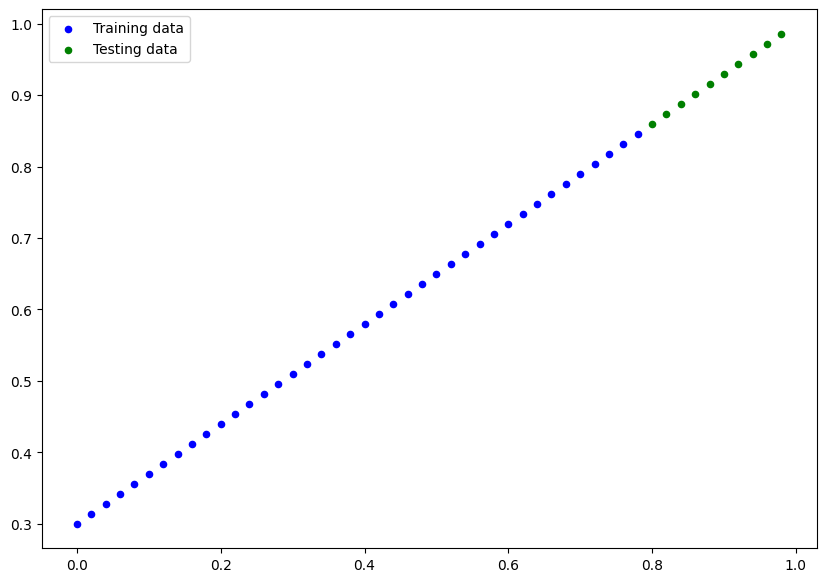

In [24]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=20, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=20, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=20, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 10})
plot_predictions();

In [25]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

In [26]:
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)

    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed when creating the model (this isn't always need but is used for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [27]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_1 = LinearRegressionModelV2()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_1.parameters())

[Parameter containing:
 tensor([[0.7645]], requires_grad=True),
 Parameter containing:
 tensor([0.8300], requires_grad=True)]

In [29]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds, y_test
# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   y_preds = model_0(X_test)

(tensor([[1.4416],
         [1.4569],
         [1.4722],
         [1.4875],
         [1.5028],
         [1.5181],
         [1.5334],
         [1.5487],
         [1.5640],
         [1.5793]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

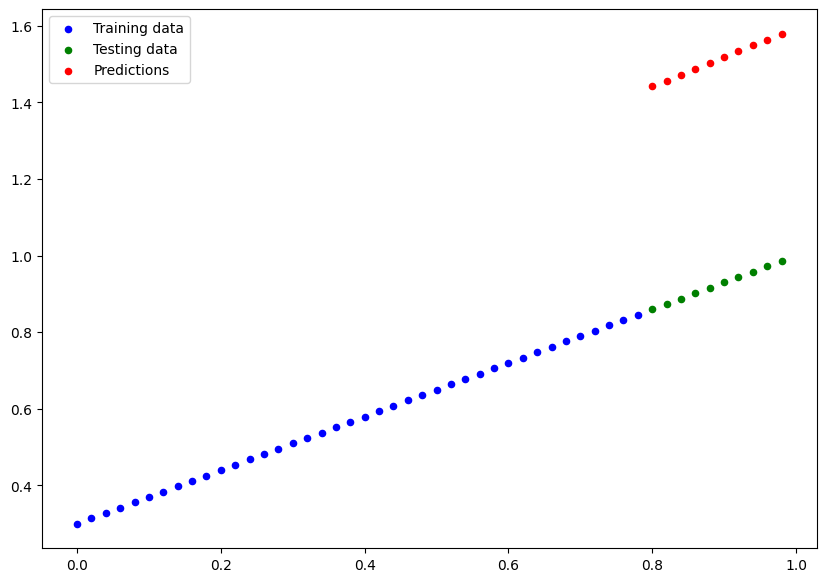

In [30]:
plot_predictions(predictions=y_preds)

In [31]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

In [37]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_1.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_1(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_1.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_1(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

     # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.0012645035749301314 | MAE Test Loss: 0.013801807537674904 
Epoch: 10 | MAE Train Loss: 0.0012645035749301314 | MAE Test Loss: 0.013801807537674904 
Epoch: 20 | MAE Train Loss: 0.0012645035749301314 | MAE Test Loss: 0.013801807537674904 
Epoch: 30 | MAE Train Loss: 0.0012645035749301314 | MAE Test Loss: 0.013801807537674904 
Epoch: 40 | MAE Train Loss: 0.0012645035749301314 | MAE Test Loss: 0.013801807537674904 
Epoch: 50 | MAE Train Loss: 0.0012645035749301314 | MAE Test Loss: 0.013801807537674904 
Epoch: 60 | MAE Train Loss: 0.0012645035749301314 | MAE Test Loss: 0.013801807537674904 
Epoch: 70 | MAE Train Loss: 0.0012645035749301314 | MAE Test Loss: 0.013801807537674904 
Epoch: 80 | MAE Train Loss: 0.0012645035749301314 | MAE Test Loss: 0.013801807537674904 
Epoch: 90 | MAE Train Loss: 0.0012645035749301314 | MAE Test Loss: 0.013801807537674904 


In [33]:
with torch.inference_mode():
 y_pred_new = model_1(X_test)

model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6691]])),
             ('linear_layer.bias', tensor([0.3130]))])

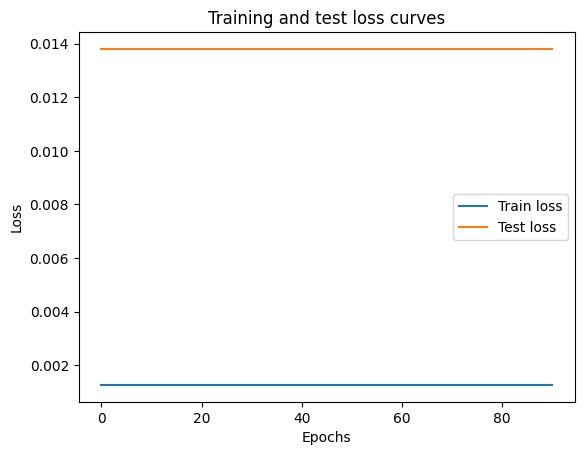

In [38]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

From here model saving started. Don't need right now..

In [39]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [43]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()
device = "cpu"
# Load model state dict
loaded_model_1.load_state_dict(torch.load("/content/models/01_pytorch_workflow_model_1.pth"))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cpu


In [44]:
# 1. Put the loaded model into evaluation mode
loaded_model_1.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_1(X_test) # perform a forward pass on the test data with the loaded model

In [45]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_pred_new == loaded_model_preds

tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False]])